In [139]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import torch
from distutils.util import strtobool
import random

import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [131]:
if not os.path.exists("data"):
    # If the directory does not exist, create it
    os.makedirs("data")
    print(f"Directory data created.")
else:
    print(f"Directory data already exists.")

!zenodo_get 10.5281/zenodo.5129073 # This is a wikipedia data set
!mv temperature_rain_dataset_with_missing_values.zip data/temperature_rain_dataset_with_missing_values.zip
!unzip data/temperature_rain_dataset_with_missing_values.zip -d data
!rm md5sums.txt

Directory data already exists.


Title: Temperature Rain Dataset with Missing Values
Keywords: temperature, rain, daily series, forecasting
Publication date: 2021-07-23
DOI: 10.5281/zenodo.5129073
Total size: 24.6 MB

Link: https://zenodo.org/record/5129073/files/temperature_rain_dataset_with_missing_values.zip   size: 24.6 MB
100% [....................................................] 25747139 / 25747139
Checksum is correct. (aea3c238e2f0ab573d4e55502a6e07a5)
All files have been downloaded.
Archive:  data/temperature_rain_dataset_with_missing_values.zip
  inflating: data/temperature_rain_dataset_with_missing_values.tsf  


In [132]:
# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="utf-8") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


test_data = convert_tsf_to_dataframe(
    "data/temperature_rain_dataset_with_missing_values.tsf"
)

In [133]:
df = test_data[0]
df.shape
df

,series_name,station_id,obs_or_fcst,start_timestamp,series_value
0,T0,1006,T_MEAN,2015-05-02 15:00:00,"[24.79167, 25.11667, 26.84167, 27.87917, 28.34..."
1,T1,1006,PRCP_SUM,2015-05-02 15:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,T2,1006,T_MAX,2015-05-02 15:00:00,"[35.8, 36.6, 38.7, 38.6, 35.9, 33.6, 33.8, 34...."
3,T3,1006,T_MIN,2015-05-02 15:00:00,"[15.7, 15.3, 16.7, 18.8, 20.9, 20.1, 15.9, 16...."
4,T4,1006,fcst_0_DailyPoP,2015-05-02 15:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, NaN, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
32067,T32067,200786,fcst_5_DailyPrecip,2015-05-02 15:00:00,"[0.41911, 0.80749, 1.27236, 2.36317, 0.69048, ..."
32068,T32068,200786,fcst_5_DailyPrecip10Pct,2015-05-02 15:00:00,"[1.27522, 2.31377, 3.90345, 7.31868, 2.12006, ..."
32069,T32069,200786,fcst_5_DailyPrecip25Pct,2015-05-02 15:00:00,"[0.2614, 0.19993, 0.60498, 1.19046, 0.40992, 0..."
32070,T32070,200786,fcst_5_DailyPrecip50Pct,2015-05-02 15:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, NaN, ..."


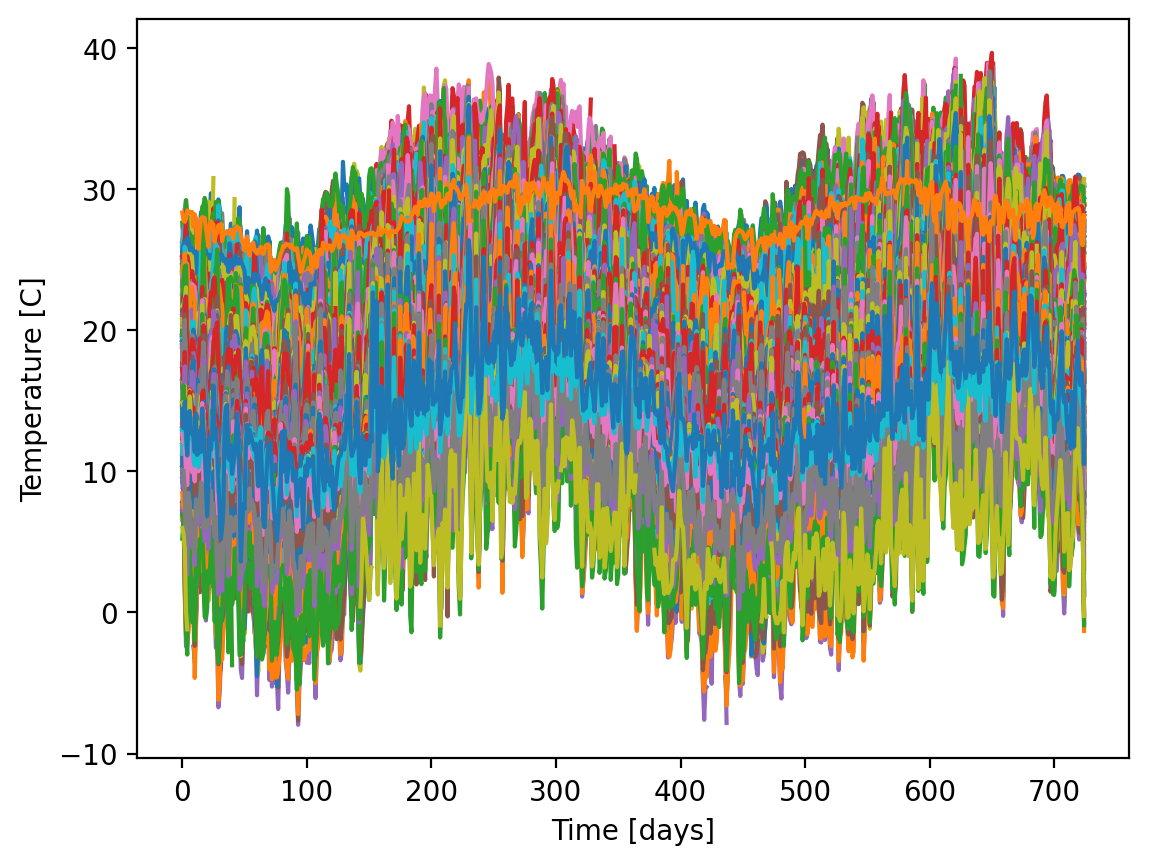

In [134]:
T_means = df[df["obs_or_fcst"] == "T_MEAN"]["series_value"]
T_means = np.array(T_means.tolist())

for i in range(T_means.shape[0]):
    plt.plot(T_means[i])

plt.xlabel("Time [days]")
plt.ylabel("Temperature [C]")
plt.show()

In [143]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_sequence_length):
        self.data = data
        self.max_sequence_length = max_sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        series = self.data[idx]
        assert len(series) > self.max_sequence_length

        # Randomly select a starting point for the sequence
        start_index = random.randint(0, len(series) - self.max_sequence_length)

        # Slice the series to get a random subsequence of length max_sequence_length
        series = series[start_index : start_index + self.max_sequence_length]

        return torch.tensor(series, dtype=torch.float32).unsqueeze(-1)


# Example usage
data_array = np.random.rand(422, 725)  # Replace with your actual data array
max_sequence_length = 512  # Adjust as needed to match your transformer architecture

dataset = TimeSeriesDataset(data_array, max_sequence_length)
dataloader = DataLoader(
    dataset, batch_size=2, shuffle=True
)  # Adjust batch_size as needed

# Example loop for training (skeleton)
for batch in dataloader:
    # Your training code here, using 'batch' as the input
    print(batch.shape)

torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 512, 1])
torch.Size([2, 5